<a href="https://colab.research.google.com/github/Untick/IrisID_gr2/blob/Alexey-Tatarinov-folder/Alexey%20Tatarinov/%D0%98%D0%B4%D0%B5%D0%BD%D1%82%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%BF%D0%BE_%D1%80%D0%B0%D0%B4%D1%83%D0%B6%D0%BA%D0%B5_%D0%97%D0%95%D0%9D%D0%98%D0%A6%D0%90_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Импортирование библиотек**

In [1]:
import numpy as np

from keras.applications import VGG19, ResNet50, Xception

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten, 
                                     Dropout, BatchNormalization, Rescaling,
                                     GlobalAveragePooling2D, RandomFlip, Input,
                                     RandomRotation, RandomZoom, RandomContrast)

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from PIL import ImageEnhance

import gdown

import os

import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline


# **Задание гиперпараметров**

In [2]:
TRAIN_PATH          = '/content/drive/MyDrive/iris_ds'
VAL_SPLIT           = 0.2

IMG_WIDTH           = 320
IMG_HEIGHT          = 240
IMG_CHANNELS        = 3

ROTATION_RANGE      = 15
WIDTH_SHIFT_RANGE   = 0.1
HEIGHT_SHIFT_RANGE  = 0.1
ZOOM_RANGE          = 0.15
BRIGHTNESS_RANGE    = (0.8, 1.2)
HORIZONTAL_FLIP     = True

EPOCHS              = 50
BATCH_SIZE          = 24
OPTIMIZER           = tf.keras.optimizers.legacy.Adam(0.0001)

# **Загрузка датасета**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import files
# !zip -r folder.zip /content/drive/MyDrive/iris_ds
# files.download('folder.zip')


In [ ]:
# import zipfile
# zip_ref = zipfile.ZipFile('folder.zip', 'r')
# zip_ref.extractall('/content/drive/MyDrive/iris_ds')
# zip_ref.close()

# import mimetypes

# file_path = '/content/iris1_8'
# file_type, encoding = mimetypes.guess_type(file_path)
# print(file_type)

# **Создание модели с собственным генератором**

### **Разметка датасета**

In [ ]:
train_ds, validation_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_PATH,
  validation_split=0.15,
  subset="both",
  label_mode = 'categorical',
  color_mode = "rgb",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

print(train_ds.element_spec)

class_names = train_ds.class_names
print(class_names)

Found 384 files belonging to 64 classes.
Using 327 files for training.
Using 57 files for validation.
(TensorSpec(shape=(None, 240, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64), dtype=tf.float32, name=None))
['client_1', 'client_10', 'client_11', 'client_12', 'client_13', 'client_14', 'client_15', 'client_16', 'client_17', 'client_18', 'client_19', 'client_2', 'client_20', 'client_21', 'client_22', 'client_23', 'client_24', 'client_25', 'client_26', 'client_27', 'client_28', 'client_29', 'client_3', 'client_30', 'client_31', 'client_32', 'client_33', 'client_34', 'client_35', 'client_36', 'client_37', 'client_38', 'client_39', 'client_4', 'client_40', 'client_41', 'client_42', 'client_43', 'client_44', 'client_45', 'client_46', 'client_47', 'client_48', 'client_49', 'client_5', 'client_50', 'client_51', 'client_52', 'client_53', 'client_54', 'client_55', 'client_56', 'client_57', 'client_58', 'client_59', 'client_6', 'client_60', 'client_61', 'client_62', 'client_

In [ ]:
image_batch, _ = next(iter(train_ds))

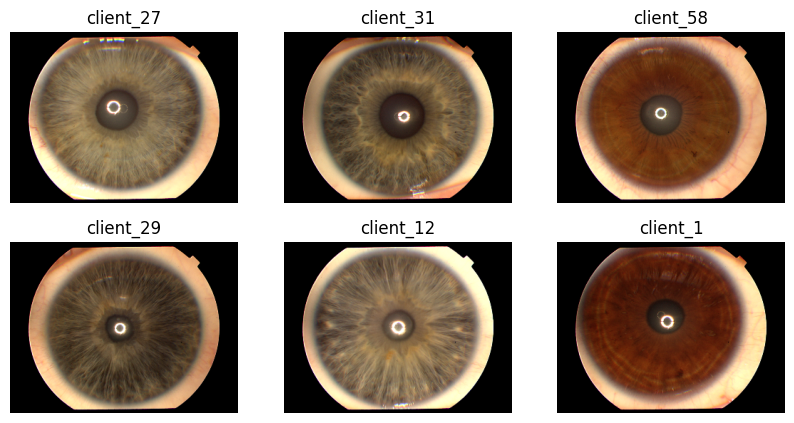

In [ ]:
plt.figure(figsize=(10, 5))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

### **Оптимизация обучения нейронной сети**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Аугментация данных**

In [ ]:
!pip -q install focal-loss
from focal_loss import SparseCategoricalFocalLoss

image_shape = train_ds.element_spec[0].shape[1:]
checkpoint = ModelCheckpoint(filepath="my_model.hdf5", monitor="val_loss", verbose=0, save_best_only=True)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomZoom((-0.1, 0.1)),
  tf.keras.layers.RandomContrast(0.1),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomBrightness(0.1),
  # tf.keras.layers.RandomFlip(mode="horizontal"),
  ])   

inputs = tf.keras.Input(shape=(image_shape))
x = data_augmentation(inputs)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(len(class_names), 
                activation='softmax'
)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(
              optimizer=OPTIMIZER,
              loss='categorical_crossentropy',
              # tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics='accuracy')


### **Обучение модели**

In [ ]:
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=EPOCHS,
  callbacks=checkpoint,
  )

Epoch 1/10
15/15 [==============================] - 121s 8s/step - loss: 4.4517 - accuracy: 0.0231 - val_loss: 65.7059 - val_accuracy: 0.0000e+00
Epoch 2/10
15/15 [==============================] - 116s 8s/step - loss: 4.2621 - accuracy: 0.0347 - val_loss: 46.1730 - val_accuracy: 0.0000e+00
Epoch 3/10
15/15 [==============================] - 118s 8s/step - loss: 4.1045 - accuracy: 0.0347 - val_loss: 25.5386 - val_accuracy: 0.0000e+00
Epoch 4/10
15/15 [==============================] - 153s 10s/step - loss: 4.1244 - accuracy: 0.0462 - val_loss: 13.6292 - val_accuracy: 0.0263
Epoch 5/10
15/15 [==============================] - 134s 9s/step - loss: 4.0026 - accuracy: 0.0607 - val_loss: 9.2716 - val_accuracy: 0.0263
Epoch 6/10
15/15 [==============================] - 130s 9s/step - loss: 4.0046 - accuracy: 0.0578 - val_loss: 6.4257 - val_accuracy: 0.0000e+00
Epoch 7/10
15/15 [==============================] - 132s 9s/step - loss: 3.9146 - accuracy: 0.0549 - val_loss: 5.5617 - val_accuracy:

# **Создание модели с ImageDataGenerator**

### **Разметка датасета**

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 64, метки классов: ['client_1', 'client_10', 'client_11', 'client_12', 'client_13', 'client_14', 'client_15', 'client_16', 'client_17', 'client_18', 'client_19', 'client_2', 'client_20', 'client_21', 'client_22', 'client_23', 'client_24', 'client_25', 'client_26', 'client_27', 'client_28', 'client_29', 'client_3', 'client_30', 'client_31', 'client_32', 'client_33', 'client_34', 'client_35', 'client_36', 'client_37', 'client_38', 'client_39', 'client_4', 'client_40', 'client_41', 'client_42', 'client_43', 'client_44', 'client_45', 'client_46', 'client_47', 'client_48', 'client_49', 'client_5', 'client_50', 'client_51', 'client_52', 'client_53', 'client_54', 'client_55', 'client_56', 'client_57', 'client_58', 'client_59', 'client_6', 'client_60', 'client_61', 'client_62', 'client_63', 'client_64', 'client_7', 'client_8', 'client_9']


### **Аугментация изображений**

In [ ]:
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )


In [ ]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 320 images belonging to 64 classes.
Found 64 images belonging to 64 classes.


In [ ]:
# Проверка формы данных
print(f'Формы данных тренировочной выборки: {train_generator[0][0].shape}, {train_generator[0][1].shape}, батчей: {len(train_generator)}')
print(f'Формы данных   проверочной выборки: {validation_generator[0][0].shape}, {validation_generator[0][1].shape}, батчей: {len(validation_generator)}')

print()

# Проверка назначения меток классов
print(f'Метки классов тренировочной выборки: {train_generator.class_indices}')
print(f'Метки классов   проверочной выборки: {validation_generator.class_indices}')


Формы данных тренировочной выборки: (24, 240, 320, 3), (24, 64), батчей: 14
Формы данных   проверочной выборки: (24, 240, 320, 3), (24, 64), батчей: 3

Метки классов тренировочной выборки: {'client_1': 0, 'client_10': 1, 'client_11': 2, 'client_12': 3, 'client_13': 4, 'client_14': 5, 'client_15': 6, 'client_16': 7, 'client_17': 8, 'client_18': 9, 'client_19': 10, 'client_2': 11, 'client_20': 12, 'client_21': 13, 'client_22': 14, 'client_23': 15, 'client_24': 16, 'client_25': 17, 'client_26': 18, 'client_27': 19, 'client_28': 20, 'client_29': 21, 'client_3': 22, 'client_30': 23, 'client_31': 24, 'client_32': 25, 'client_33': 26, 'client_34': 27, 'client_35': 28, 'client_36': 29, 'client_37': 30, 'client_38': 31, 'client_39': 32, 'client_4': 33, 'client_40': 34, 'client_41': 35, 'client_42': 36, 'client_43': 37, 'client_44': 38, 'client_45': 39, 'client_46': 40, 'client_47': 41, 'client_48': 42, 'client_49': 43, 'client_5': 44, 'client_50': 45, 'client_51': 46, 'client_52': 47, 'client_5

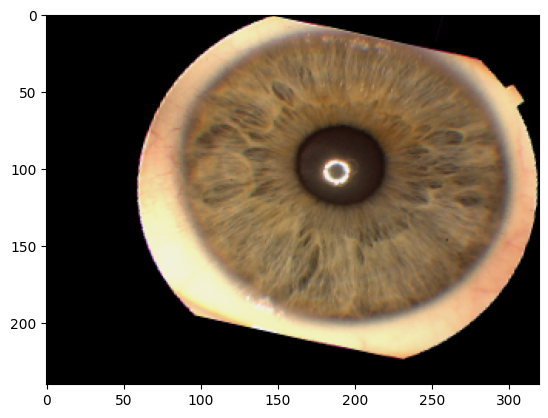

In [ ]:
plt.imshow(train_generator[1][0][2])
plt.show()

### **Создание и обучение нейронной сети**

In [ ]:
def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(train_data,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=val_data)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'], 
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'], 
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'], 
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'], 
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 240, 320, 64)      1792      
                                                                 
 batch_normalization_4 (Batc  (None, 240, 320, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 240, 320, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 80, 106, 64)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 80, 106, 64)       0         
                                                                 
 batch_normalization_5 (Batc  (None, 80, 106, 64)     

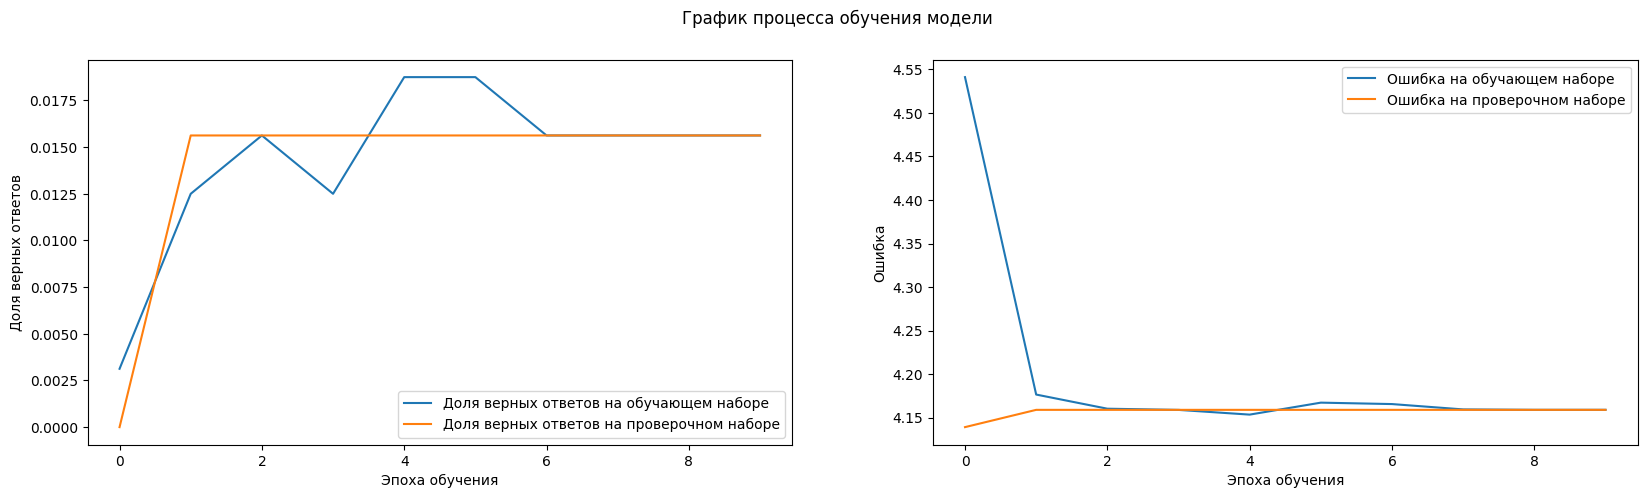

In [ ]:
model_iris = Sequential()

model_iris.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
model_iris.add(BatchNormalization())

model_iris.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_iris.add(MaxPooling2D(pool_size=(3, 3)))
model_iris.add(Dropout(0.2))

# model_iris.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# model_iris.add(BatchNormalization())

model_iris.add(Flatten())

model_iris.add(Dense(32, activation='relu'))

model_iris.add(Dense(CLASS_COUNT, activation='softmax')) 

compile_train_model(model_iris,
                    train_generator,
                    validation_generator,
                    )

# **Создание модели с использованием предобученных сетей**

In [ ]:
train_ds, validation_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_PATH,
  validation_split=0.15,
  subset="both",
  label_mode = 'categorical',
  color_mode = "rgb",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

print(train_ds.element_spec)

class_names = train_ds.class_names
print(class_names)

Found 384 files belonging to 64 classes.
Using 327 files for training.
Using 57 files for validation.
(TensorSpec(shape=(None, 240, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64), dtype=tf.float32, name=None))
['client_1', 'client_10', 'client_11', 'client_12', 'client_13', 'client_14', 'client_15', 'client_16', 'client_17', 'client_18', 'client_19', 'client_2', 'client_20', 'client_21', 'client_22', 'client_23', 'client_24', 'client_25', 'client_26', 'client_27', 'client_28', 'client_29', 'client_3', 'client_30', 'client_31', 'client_32', 'client_33', 'client_34', 'client_35', 'client_36', 'client_37', 'client_38', 'client_39', 'client_4', 'client_40', 'client_41', 'client_42', 'client_43', 'client_44', 'client_45', 'client_46', 'client_47', 'client_48', 'client_49', 'client_5', 'client_50', 'client_51', 'client_52', 'client_53', 'client_54', 'client_55', 'client_56', 'client_57', 'client_58', 'client_59', 'client_6', 'client_60', 'client_61', 'client_62', 'client_

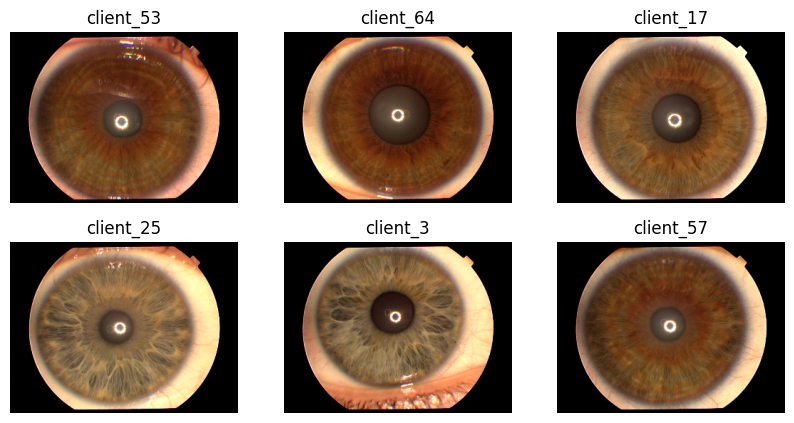

In [ ]:
plt.figure(figsize=(10, 5))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [ ]:
image_shape = train_ds.element_spec[0].shape[1:]
checkpoint = ModelCheckpoint(filepath="my_model.hdf5", monitor="val_loss", verbose=0, save_best_only=True)

In [ ]:
# vgg19_preprocess_input = tf.keras.applications.vgg19.preprocess_input
# vgg19_layer = tf.keras.applications.vgg19.VGG19(input_shape=image_shape,
#                          include_top=False,
#                          weights='imagenet')

# xception_preprocess_input = tf.keras.applications.xception.preprocess_input
# xception_layer = tf.keras.applications.xception.Xception(input_shape=image_shape,
#                          include_top=False,
#                          weights='imagenet')

resnet50_preprocess_input = tf.keras.applications.resnet50.preprocess_input
resnet50_layer = tf.keras.applications.resnet50.ResNet50(input_shape=image_shape,
                         include_top=False,
                         weights='imagenet')

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomZoom((-0.1, 0.1)),
  tf.keras.layers.RandomContrast(0.1),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomBrightness(0.1),
  # tf.keras.layers.RandomFlip(mode="horizontal"),
  ])   

inputs = tf.keras.Input(shape=(image_shape))
x = data_augmentation(inputs)
# x = vgg19_preprocess_input(x)
# x = vgg19_layer(x, training=False)
x = resnet50_preprocess_input(x)
x = resnet50_layer(x, training=False)
# x = xception_preprocess_input(x)
# x = xception_layer(x, training=False)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
# x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
# x = BatchNormalization()(x)
# x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
# x = Flatten()(x)
# x = Dense(100, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dense(50, activation='relu')(x)
# x = Dropout(0.2)(x)
outputs = Dense(len(class_names), 
                activation='softmax'
)(x)
model = tf.keras.Model(inputs, outputs)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model.compile(
              optimizer=OPTIMIZER,
              loss='categorical_crossentropy',
              # tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics='accuracy')

In [ ]:
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=EPOCHS,
  callbacks=checkpoint,
  )

Epoch 1/50
14/14 [==============================] - 68s 4s/step - loss: 4.2886 - accuracy: 0.0245 - val_loss: 4.1822 - val_accuracy: 0.0175
Epoch 2/50
14/14 [==============================] - 8s 454ms/step - loss: 4.1344 - accuracy: 0.0275 - val_loss: 4.2325 - val_accuracy: 0.0000e+00
Epoch 3/50
14/14 [==============================] - 9s 513ms/step - loss: 4.0417 - accuracy: 0.0398 - val_loss: 3.9737 - val_accuracy: 0.0702
Epoch 4/50
14/14 [==============================] - 10s 545ms/step - loss: 3.8399 - accuracy: 0.0428 - val_loss: 3.8686 - val_accuracy: 0.0175
Epoch 5/50
14/14 [==============================] - 9s 550ms/step - loss: 3.5452 - accuracy: 0.0826 - val_loss: 3.4272 - val_accuracy: 0.0877
Epoch 6/50
14/14 [==============================] - 9s 547ms/step - loss: 3.0522 - accuracy: 0.1560 - val_loss: 2.7478 - val_accuracy: 0.1930
Epoch 7/50
14/14 [==============================] - 10s 519ms/step - loss: 2.4789 - accuracy: 0.3028 - val_loss: 1.9739 - val_accuracy: 0.4912
Ep

In [ ]:
model_resnet50 = model.save_weights(filepath='model_weights_resnet50.h5')


# **Использование AutoML**

In [4]:
!pip install autokeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.8/466.8 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 98.3 MB/s eta 0:00:00


In [8]:
train_ds, validation_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_PATH,
  validation_split=0.15,
  subset="both",
  label_mode = 'categorical',
  color_mode = "rgb",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

print(train_ds.element_spec)

class_names = train_ds.class_names
print(class_names)

Found 384 files belonging to 64 classes.
Using 327 files for training.
Using 57 files for validation.
(TensorSpec(shape=(None, 240, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64), dtype=tf.float32, name=None))
['client_1', 'client_10', 'client_11', 'client_12', 'client_13', 'client_14', 'client_15', 'client_16', 'client_17', 'client_18', 'client_19', 'client_2', 'client_20', 'client_21', 'client_22', 'client_23', 'client_24', 'client_25', 'client_26', 'client_27', 'client_28', 'client_29', 'client_3', 'client_30', 'client_31', 'client_32', 'client_33', 'client_34', 'client_35', 'client_36', 'client_37', 'client_38', 'client_39', 'client_4', 'client_40', 'client_41', 'client_42', 'client_43', 'client_44', 'client_45', 'client_46', 'client_47', 'client_48', 'client_49', 'client_5', 'client_50', 'client_51', 'client_52', 'client_53', 'client_54', 'client_55', 'client_56', 'client_57', 'client_58', 'client_59', 'client_6', 'client_60', 'client_61', 'client_62', 'client_

In [9]:
import autokeras as ak

clf = ak.ImageClassifier(
    max_trials=3,
    objective='val_accuracy',
    directory='automl_irisID_1',
    overwrite=True)

clf.fit(train_ds, class_names, epochs=10, validation_split=0.15)

ValueError: ignored